# Naive Bayes

Naive Bayes refers to the use of Bayes' theorem with naive independence assumptions between features.

Naive Bayes classifers are popular for categorizing text. The goal of this module is to learn the basics of Naive Bayes. The module is split into a few sections:

+ Prepare the data for analysis
+ Introduction to Naive Bayes
+ Tokenization
+ Vectorization
+ Prediction
+ Evaluation

This module coincides with our lecture on natural language processing with Naive Bayes.

However before we delve into section 1 on data preparation, we will begin by doing an overview of the data we're using. For the reader's understanding of the methodology, we:

1. First, pulled the Twitter data related to microfinance using tweepy, a Twitter API library. 
2. Next, we classified the comments into sentiment polarities in order to obtain training data for our model. 
    + Normally this process would require manually classifying ~20% of our data. 
    + In our exercise, we leveraged a simple wordnet algorithm called TextBlob to tag the entire data set. 
3. We then manually reviewed and corrected classiications. 
    + (Note, if you are interested in seeing the code used to implement this, see the file titled "twitter_web_scraping.") 

In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
import re
import itertools
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
#load data and add a column for sentiment based on polarity
data = pd.read_csv("microfinance_tweets.csv", encoding="ISO-8859-1")

#check data to see if everything worked
data.head(10)

,Comments,Date,Favorites,User,Polarity,Sentiment
0,RT @atmadiprayET: Here's why Janalakshmi Finan...,3/22/2018 5:40,0,Saloni Shukla,-0.100000,negative
1,RT @ecosmob: Ecosmob's #Mobility solutions for...,3/22/2018 5:36,0,Sindhav Bhageerath,-0.062500,neutral
2,Project have big future! Microfinance is belie...,3/22/2018 5:27,0,Konstantin #savedroidICO,0.166667,positive
3,#Online #Banking- Yako Microfinance Bank prov...,3/22/2018 5:21,0,YakoMicrofinance,0.500000,positive
4,MICROFINANCE EVENT: 3rd BoP Global Network Sum...,3/22/2018 5:19,0,MicroCapital,0.045455,positive
5,RT @FINCA: .@rupertscofield spoke with @techwe...,3/22/2018 5:08,0,Right Angles,0.000000,neutral
6,Capacity building and knowledge management are...,3/22/2018 5:03,0,@barbara_zawedde,0.144444,positive
7,"RT @oluabudu: Get a cash loan of N200,000 to N...",3/22/2018 5:00,0,Tola Abudu,0.136364,positive
8,RT @PoojaMedia: From being an influencer for a...,3/22/2018 4:59,0,idee,0.000000,neutral
9,RT @WhatWorksVAWG: Read latest blog from Erin ...,3/22/2018 4:58,0,Sofia Sprechmann,0.500000,positive


The Twitter data contains six columns:
+ Comments: the Twitter post that was made mentionining microfinance
+ Date: date the post was created on Twitter
+ Favorites: number of favorites the post has
+ User: name of the user who posted the comment
+ Polarity: the polarity, representing the degree of positivity versus negatvity that textblob deemed the post
+ Sentiment: a conversion of polarity into positive, negative, and neutral classifications

Note that this exercise really does simulate what would happen in a real world situation. Our data is limited, and the process to get the quality training and test data we need (with labeled polarity) is a diffult one. To understand the nature of our data, we will conduct a few exercises below.

neutral     1943
positive    1039
negative     259
Name: Sentiment, dtype: int64

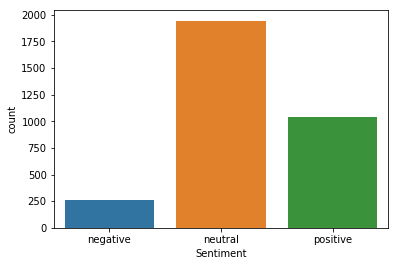

In [4]:
## What do we have for sentiment breakdown?
sns.countplot(x = 'Sentiment', data = data)
data['Sentiment'].value_counts()

It looks like most people have positive or neutral comments about microfinance. In fact, the volume of negative comments is the most interesting and should be investigated further.

In [5]:
## What are these negative comments?
#format columns so comments don't get cut off
pd.set_option('display.max_columns', None) 
pd.set_option('max_colwidth', 800)

#pull negative comments
pd.DataFrame(data.loc[data['Sentiment'] == 'negative']['Comments'].unique()[0:10])

,0
0,RT @atmadiprayET: Here's why Janalakshmi Financial takes so long to small finance bank transition https://t.co/traKQNXuxe via @economictime
1,Here's why Janalakshmi Financial takes so long to small finance bank transition https://t.co/traKQNXuxe via https://t.co/6fk3hc1S9I
2,"RT @The_LHoFT: Why Luxembourg? ???\r\nA few of the reasons why #Luxembourg is home to a growing number of financial services innovators, inclu"
3,@DataMufti Isnt it surprising that Telenor sold half of its Tameer microfinance stake to Alipay!!! To me it looks like a wrong move.
4,+???? ????? ???? ??????? ???? \r\n?????? :NMB MICROFINANCE BITTIYA SANSTHA LIMITED \r\n?? \r\n?.Junior Field Officer \r\n?.Assi https://t.co/4onBO7RMTc
5,"HR Administrative Assistant at Crossover Microfinance Bank Limited Crossover Microfinance Bank Limited, is ... https://t.co/C9b5PAKKm9"
6,"If the bank of Ghana is being this harsh on commercial banks, what will become of savings and loans and microfinanc https://t.co/pNO7yTJPS8"
7,RT @ankuranga: NPLs ratio in the Microfinance Sector decreased from 9.0% in December 2016 to 8.2% in December 2017 \r\n\r\n#MPFSS2018 #Rwanda #Rw
8,"Valued customer,\r\nBeware of this Fake page impersonating Faulu Kenya. Faulu Microfinance Bank does not have any con https://t.co/aGZlMAZqag"
9,#Salary #Loan - Yako Microfinance #Salary Loan to Employees of reputed organisations having at least six months of https://t.co/SVKpFmDlfu


It seems like some of the negative comments are not valid and should actually be classified as neutral. However, some of the negative comments are valid, e.g. fake page notice and illegal activity. 

While there is much more we could investigate about the data, we will move forward to preparing our data for the model.

# Prepare data for the model

The most common way to apply machine learning algorithms, such as Naive Bayes, to text analysis is to convert our text into numerical feature vectors that the algorithms can understand.

The representation we will create is the **Bag of Words**. To get from our data, which is currently structured as a Series of strings, to a Bag of Words, we will **vectorize** our tweets.

This **vectorization** of our text documents will require a few key steps, which we describe in more detail in [Module 8](https://docs.google.com/presentation/d/1vaxDuUROgaqix9Mfkyb4_h0cGkGwN7AUeLU1ozhtJW8/edit#slide=id.g227403103b_0_1171):

Step 0. Split data into training and test sets (this is not part of vectorization) <br>
Step 1. Clean and **tokenize** text <br>
Step 2. Count the number of words in each document

#### Step 0: Create training and test data
This step should come naturally. 
We have classified sentiments for all our data, and we choose an 80-20 training and test split, with observations assigned at random. 

In [10]:
# A) Create a set of test (20% of data) and training (80% of data) data
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [11]:
# Check the length of the training and test sets to confirm data was split in the correct porportions
print(len(train), len(test))
print("Split of {:.2%} train, {:.2%} test".format(len(train)/len(data), len(test)/len(data)))

2592 649
Split of 79.98% train, 20.02% test


#### Step 1: Clean and Tokenize Text

As mentioned, the most common way to extract numerical vectors from text is to have a set of text **tokens** for which we can have counts.

**Tokenization** means to convert a document/sentence/tweet into individual *tokens*, which are usually words, or word-like units. 

When creating these word-like tokens, we want to standardize them in a way that groups words with similar intent. This makes these token features more useful than unprocessed words. Check out the [NLP Module](https://docs.google.com/presentation/d/1vaxDuUROgaqix9Mfkyb4_h0cGkGwN7AUeLU1ozhtJW8/edit#slide=id.g227403103b_0_1050) for more details!

We create a function to lemmatize** these words. Luckily, NLTK has different libraries that make this task very easy.

Here we use NLTK's Tweet Tokenizer to handle an example tweet with hashtags and smileys. 

In [23]:
## From http://www.nltk.org/api/nltk.tokenize.html
tweet_tokenizer = TweetTokenizer()
example_tweet = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
tweet_tokenizer.tokenize(example_tweet)

['This',
 'is',
 'a',
 'cooool',
 '#dummysmiley',
 ':',
 ':-)',
 ':-P',
 '<3',
 'and',
 'some',
 'arrows',
 '<',
 '>',
 '->',
 '<--']

Note: The tweet tokenizer has additional capability to reduce length of some elooooongated words.

#### Step 2) Count the number of words in each 'document'

This is the step that brings our text to the representation as a *Bag of Words*.

A bag of words allows us to work with free text in a structured way. We use a simple count for our bag of words, but TF-IDF sklearn libraries are also available and can be used for other NLP problems.

We use the **CountVectorization** function from the sklearn library.

The TF-IDF Vectorizer is available by using:

`from sklearn.feature_extraction.text import TfidfVectorizer`

Note the difference in the use of the functions for fitting bag of words for test versus training data. 

In [17]:
# C) Represent the text in a bag-of-words by leveraging CountVectorization in the sklearn library.
vectorizer = CountVectorizer(tokenizer=tweet_tokenizer.tokenize)
train_features = vectorizer.fit_transform(train['Comments'])
test_features =  vectorizer.transform(test['Comments'])

In [18]:
vectorizer.get_feature_names()[0:20]

['!',
 '"',
 '#',
 '#7milliards',
 '#8mars',
 '#accountability',
 '#adel',
 '#adie30ans',
 '#adoption',
 '#africa',
 '#africanplanet',
 '#afrique',
 '#ag4dev',
 '#agm',
 '#agriculture',
 '#agricultureloans',
 '#agustoandco',
 '#ahandup',
 '#alibaba',
 '#alibaba-backed']

These are our *features*, i.e. all of the cleaned tokens from all of the tweets. A training or test tweet can now be represented as a count of how many times any of these features shows up. 

In [19]:
# Test the vectorizer by looking at the size of the vectors and snippets of the vectors
print('Length of Vectorizer Vocabulary: ', len(vectorizer.vocabulary_))
print('Shape of Sparse Matrix: ', test_features.shape)
print('Amount of Non-Zero occurrences: ', test_features.nnz)

# Percentage of non-zero values
density = 100.0 * (test_features.nnz / (test_features.shape[0] * test_features.shape[1]))
print('Density: {}'.format((density)))

Length of Vectorizer Vocabulary:  6184
Shape of Sparse Matrix:  (649, 6184)
Amount of Non-Zero occurrences:  11423
Density: 0.28462038323463107


We have 6184 *tokens* in our corpus. The test data features matrix is a representation of each of the 647 tweets as a vector of token counts. 

In [20]:
# To understand how the vectorizer stores words, we will input a sample test data review
sample_test = test['Comments'].iloc[11]
print("Sample comment: ", sample_test, "\n")
sample_vector = vectorizer.transform([sample_test])
print("Vectorization:")
print(sample_vector)

Sample comment:  IFC to boost support for microfinance in Myanmar https://t.co/PDF0xirLpz  @IFC_org #microfinance #fintech https://t.co/aRQ9FCqyDS 

Vectorization:
  (0, 150)	1
  (0, 264)	1
  (0, 852)	1
  (0, 1544)	1
  (0, 2418)	1
  (0, 3511)	1
  (0, 3999)	1
  (0, 4033)	1
  (0, 4572)	1
  (0, 4686)	1
  (0, 5681)	1
  (0, 5813)	1


In [21]:
# This means we have a word count for a word at index 755, 925, etc.
# We can use get_feature_names() on the vectorizer to see what these words are
print(list(vectorizer.get_feature_names()[i] for i in sample_vector.indices))

['#fintech', '#microfinance', '@ifc_org', 'boost', 'for', 'https://t.co/pdf0xirlpz', 'ifc', 'in', 'microfinance', 'myanmar', 'support', 'to']


Let's look at a Wordcloud of our data to see what words are most frequently showing up!

(-0.5, 1599.5, 1199.5, -0.5)

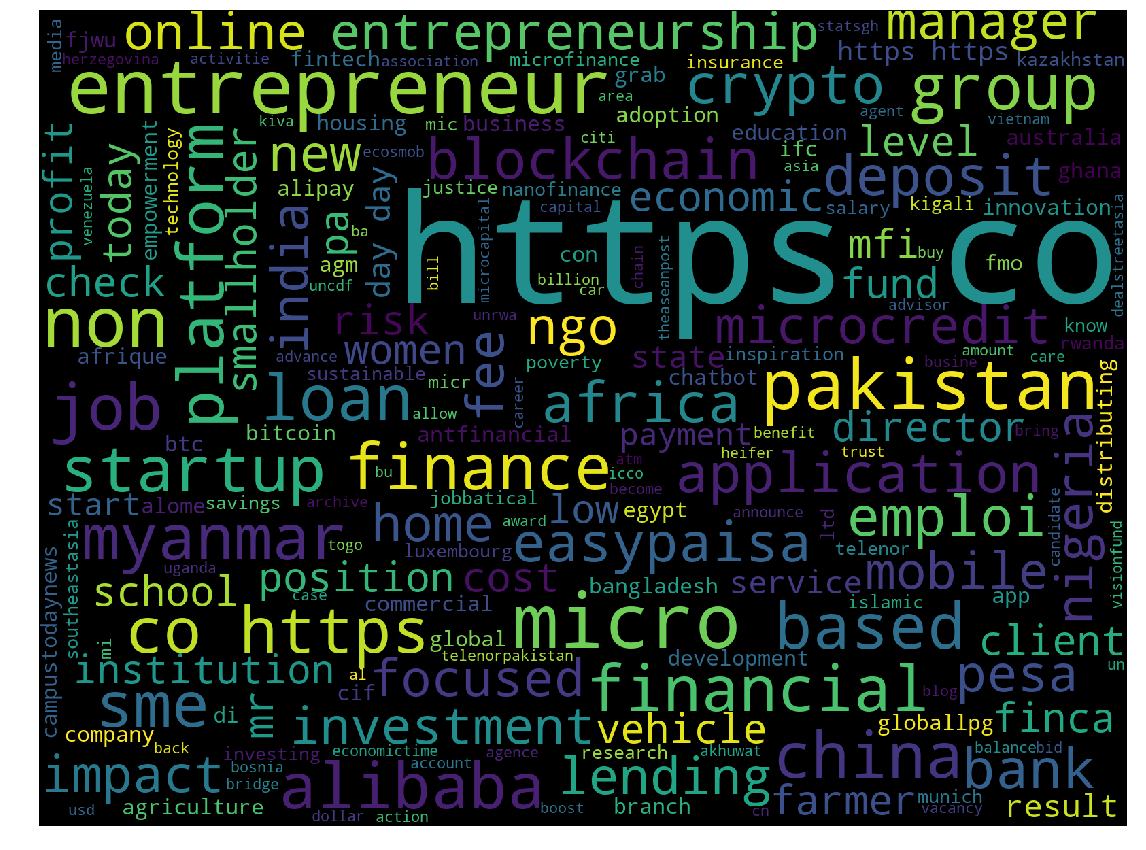

In [22]:
#cloud = WordCloud(width=1600, height=1200).generate(" ".join(data['Comments'].astype(str)))
cloud = WordCloud(width=1600, height=1200).generate(" ".join(vectorizer.get_feature_names()))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

These words make sense given our focus. We appear to have some urls (https, co).

# Introduction to Naive Bayes
We will begin by running Naive Bayes on the text and check how well it does in predicting classifications. This step is very easy given we have already prepared out data in a bag of words format. <br>

In [24]:
#train your data set using multinomial NB from sklearn library
nb = MultinomialNB()
nb.fit(train_features, train['Sentiment'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
#test your data set on your test data
preds = nb.predict(test_features)

#print the accuracy of your model
accuracy = (preds == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy.sum() / len(accuracy))

'Accuracy : 85.82%'

The accuracy is high at ~86%. Most sentiment analysis algorithms have an accuarcy of ~80% when you have fitted the model on proper training data. In this case, the 86% accuracy is likely inflated because we've used TextBlob to determine the correct sentiment in our training data. 

The current measurement of accuracy is a one-dimensional value. We don't know what we're messing up when we classify the sentiments wrong. One tool to better understand how we're misclassifying is called a confusion matrix (first introduced in the lecture on logistic regression.)

In [26]:
## Can be taken as given from sklearn confusion matrix documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 41   7   4]
 [ 29 326  42]
 [  1   9 190]]
Normalized confusion matrix
[[ 0.78846154  0.13461538  0.07692308]
 [ 0.07304786  0.82115869  0.10579345]
 [ 0.005       0.045       0.95      ]]


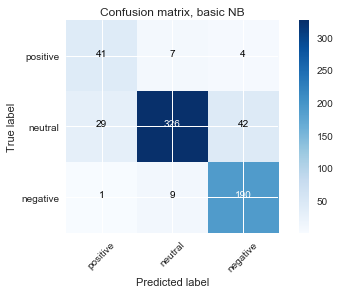

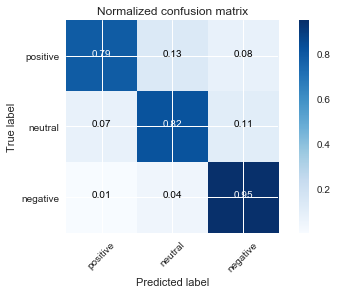

In [24]:
class_names = set(data['Sentiment'])
cnf_matrix = confusion_matrix(test['Sentiment'], preds)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, basic NB')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

The above results show that we're commonly predicting positive comments as netural. This misclassification is not as concerning as our second common misclassification of negative comments as positive.

# Conclusion

We've reviewed the basics of Naive Bayes and investigated how improvements can be used in the case of sentiment analysis. 

There are many kinds of small improvements you can make to a Naive Bayes model, and it often depends on the nature of your data. For instance, if you know the text you're using will be particularly informal, it may be good to adapt your analyzer function to account for those informalities. If the text is not informal, this adjustment will not change much to your model accuracy For more details on how improvements can be made to Naive Bayes, see the lab titled "naive_bayes_detail"

Sources: https://medium.com/tensorist/classifying-yelp-reviews-using-nltk-and-scikit-learn-c58e71e962d9, https://www.dataquest.io/blog/naive-bayes-tutorial/, http://nlpforhackers.io/sentiment-analysis-intro/, http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html <br>